# XAI Experiment Data Analysis

## Data Analysis todo list

- ✅ Import and preprocess data
- ✅ Demographics general overview 
- ✅ Performance (accuracy etc.)
  - ✅ AI vs Human vs Human-AI
  - ✅ Compare Human-AI performance among groups
  - ✅ Compare change in performance among groups
- ✅ Willingness to adjust judgments to match the AI system (Agreement percentage, switch percentage and AI preference)
  - ✅ Compare agreement percentage among groups
  - ✅ Compare switch percentage among groups
  - ✅ Compare AI preference among groups
- ✅ Effects of mistakes of the system (FP and FN)
  - ✅ Performance and willingness to adjust at FP and FN compared to other news items
  - ✅ Local evaluation metrics of FP and FN compared to other news items
- ✅ Analysis of open questions
  - ✅ What criteria do you usually use to judge whether a news/article is reliable?
  - ✅ What other information would you like to obtain to better assess the truthfulness of an article?
  - ✅ What functionality would be a good addition?
- ⚙️ Adjustments based on feedback
  - ✅ Calculate effect sizes
  - ✅ Correlation plot for education and income on AI-agreement on mistakes
  - ❔ Analyze AI-agreement on mistakes for different groups
  - ✅ Group news items into clearly true, rather fake, clearly fake, and falsely labeled
  - [ ] Show (non)significant differences on box plots
  - ✅ Show word frequencies on word clouds
  - ✅ Add some quantitative data to the qualitative analysis (e.g. frequencies of topics)

### Bonus analyses todo list
- [ ] Include journalists and interaction effects
  - [ ] Compare Human-AI performance 
  - [ ] Compare change in performance
  - [ ] Compare agreement percentage
  - [ ] Compare switch percentage
  - [ ] Compare AI preference

In [140]:
import json
import pandas as pd
import requests
import io
from urllib.request import urlopen
import json
import logging
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.json import json_normalize
import pingouin as pg
import scikit_posthocs as sp

In [141]:
%reload_ext autoreload
%autoreload 2

## Import and preprocess data

### Read questionnaire data

In [142]:
df = pd.read_csv('data/data_cleaned.csv')

### Read news items

In [143]:
newsitems = pd.read_csv('../preprocessing/news-items.csv')

In [144]:
newsitems["id"] = newsitems.index + 1
newsitems.index = newsitems.index + 1

In [145]:
# only keep the relevant columns
newsitems = newsitems[["id", "label", "group",
                       "title", "subtitle", "content",
                       "source", "publishing_date", "category",
                       "highlighted_content", "truthfulness", "readability","natural_language_explanation",
                       "is_qualification"]]

In [146]:
# only keep newsitems from group 2 and newsitems without a group (FP and TN), 
# since only these are used in the experiment
newsitems = newsitems[(newsitems["group"] == 2) | newsitems["group"].isna()]
newsitems = newsitems.drop(columns=["group"])

In [147]:
# create a new column, "is_fake_news", based on if "label" is "FAKE" or "TRUE"
newsitems["is_fake_news"] = newsitems["label"].apply(lambda x: True if x == "FAKE" else False)
newsitems = newsitems.drop(columns=["label"])

In [148]:
# remove percentage sign from truthfulness and convert to int
newsitems["truthfulness"] = newsitems["truthfulness"].apply(lambda x: int(x.replace("%", "")))

In [149]:
newsitems.head()

,id,title,subtitle,content,source,publishing_date,category,highlighted_content,truthfulness,readability,natural_language_explanation,is_qualification,is_fake_news
7,7,"Facing unbearable heat, Qatar has begun to air-condition the outdoors",2°C: BEYOND THE LIMIT,"Already one of the hottest places on Earth, Qatar has seen average temperatures rise more than 2 degrees Celsius above preindustrial times, the current international goal for limiting the damage o...",Trustworthy Source,10/16/2019,Environment,"Already one of the hottest places on Earth, Qatar has seen average temperatures rise more than 2 degrees Celsius above preindustrial times, the current international goal for limiting the damage o...",90,medium,Qatar is one of the hottest countries on earth. That’s already taken a deadly toll on many involved in event preparations. Since the average November high temperature in the Gulf state is around 8...,False,False
8,8,Survival International launches campaign to stop “30x30” – “the biggest land grab in history”,NaN,Survival International today (Earth Day) launched a major new campaign to stop the plan to turn 30% of Earth into Protected Areas by 2030. The plan by world leaders and conservation organizations ...,Untrustworthy Source,04/22/2022,Environment,Survival International today (Earth Day) launched a major new campaign to stop the plan to turn 30% of Earth into Protected Areas by 2030. The plan by world leaders and conservation organizations ...,47,medium,"The statement by Survival International that 300 million people stand to lose their land and livelihoods under the 30x30 plan, with ""most"" being tribal and indigenous peoples, is based on a study ...",False,True
9,9,"How Biden's climate plan could limit you to eat just one burger a MONTH, cost $3.5K a year per person in taxes, force you to spend $55K on an electric car and 'crush' American jobs",NaN,"President Joe Biden's ambitious plan to slash greenhouse emissions by 50 to 52 percent over the next decade could prompt sweeping changes that could affect how Americans eat, drive and heat their ...",Untrustworthy Source,04/22/2021,Environment,President Joe Biden's ambitious plan to <span style='background-color:#00FEFE'>slash</span> greenhouse emissions by 50 to 52 percent over the next decade could prompt sweeping changes that could a...,5,easy,"President Joe Biden’s climate plans do not include restrictions on red meat consumption, the White House said. Biden never mentioned red meat when he announced his plan to reduce U.S. greenhouse g...",False,True
10,10,Several Israelis wounded in attack on Jerusalem bus,Israeli police arrest suspected gunman after a shooting attack on a bus in Jerusalem’s Old City wounded at least eight people.,"Israeli police arrested a suspect in a shooting attack on a bus in Jerusalem’s Old City that wounded at least eight people, two critically. The attack took place in the early hours of Sunday as th...",Trustworthy Source,8/14/2022,Crime,"""<mark>Israeli police arrested a suspect in a shooting attack on a bus in Jerusalem’s Old City that wounded at least eight people, two critically.</mark> The attack took place in the early hours o...",92,medium,Israeli forces have allegedly been raiding houses in the area and carrying out arrests. The article claims that the attack followed a tense week between Israel and Palestinian fighters in the Gaza...,True,False
11,11,Young Girl Hitchhiked Through The Middle East To Prove Muslims Are Peaceful. What They Did Next…,NaN,Here’s a shocking and sad story that should be shared everywhere to get the word out. An Italian woman who was hitch hiking from Italy to Israel to promote world peace was raped and murdered by Mu...,Untrustworthy Source,4/14/2016,Crime,"""<span style='background-color:#00FEFE'>Here’s a shocking and sad story that should be shared everywhere to get the word out</span>. An Italian woman who was hitch hiking from Italy to Israel to p...",21,easy,The article misleads the readers about the

### Filtering out assumed cheaters

Assume that participants who did answer at least 5 out of 6 control questions correctly were paying attention and gave valid answers.

In [150]:
# participants who did not get 2 points in the qualification shouldn't be considered
# journalists don't have a qualification score, so they should be kept
df = df[(df["POINTS.qualification"].isna()) | (df['POINTS.qualification'] == 2)]

In [151]:
# journalists don't have a main score, so they should be kept
df = df[(df["POINTS.main"].isna()) | (df["POINTS.main"] >= 5)]

In [152]:
# filter out journalists who didn't reach enough points in the merged task
df = df[df["POINTS"] >= 7]

In [153]:
def lay(data):
    return data[data["JOURNALIST"] == False]

In [154]:
# only lay participants are considered
df = lay(df)

## Demographics

In [155]:
# get columns which start with "demographics"
demographics_cols = [col for col in df.columns if col.startswith('demographics')]
demographics_cols
# country and nationality are not relevant, since the study was conducted in the US

['demographics.age',
 'demographics.country',
 'demographics.education',
 'demographics.employment',
 'demographics.gender',
 'demographics.income',
 'demographics.nationality']

In [156]:
df["demographics.age"].value_counts(normalize=True).sort_index() * 100

18-20           3.940887
21-29          25.862069
30-39          38.423645
40-49          22.906404
50-59           6.896552
60-or-older     1.970443
Name: demographics.age, dtype: float64

In [157]:
df["demographics.education"].value_counts(normalize=True) * 100
# university degree is the most common education level, this is surprising

university         54.187192
high-school        39.655172
no-degree           2.709360
secondary           2.216749
upper-secondary     1.231527
Name: demographics.education, dtype: float64

In [158]:
df["demographics.employment"].value_counts(normalize=True) * 100

salaried-employee    36.453202
self-employed        31.773399
unemployed           13.546798
student               9.852217
other                 6.403941
civil-servant         0.738916
retiree-pensioner     0.738916
apprentice            0.492611
Name: demographics.employment, dtype: float64

In [159]:
income_vc = df["demographics.income"].value_counts(normalize=True)
print("less-than-20000-usd", income_vc["less-than-20000-usd"] * 100)
print("20000-34999-usd", income_vc["20000-34999-usd"] * 100)
print("35000-49999-usd", income_vc["35000-49999-usd"] * 100)
print("50000-74999-usd", income_vc["50000-74999-usd"] * 100)
print("75000-99999-usd", income_vc["75000-99999-usd"] * 100)
print("over-100000-usd", income_vc["over-100000-usd"] * 100)
print("no-answer", income_vc["no-answer"] * 100)

less-than-20000-usd 14.285714285714285
20000-34999-usd 17.733990147783253
35000-49999-usd 10.83743842364532
50000-74999-usd 20.44334975369458
75000-99999-usd 12.068965517241379
over-100000-usd 13.546798029556651
no-answer 11.083743842364532


In [160]:
df["demographics.gender"].value_counts(normalize=True) * 100

female     63.546798
male       35.714286
diverse     0.738916
Name: demographics.gender, dtype: float64

## Define Kruskal-Wallis test function

In [161]:
def highlight(data, highlight_any=False, alpha=0.05):
    columns = ["p-val", "p-unc", "p-corr", "p", "pval"]

    if highlight_any:
        columns = data.columns
        
    return data.style.apply(lambda x: ["text-decoration: underline" if isinstance(v, (int, float)) and v < alpha and c in columns else "" for c, v in zip(x.index, x)], axis=1)

In [162]:
def perform_kruskal_with_posthoc(df, dv, between="FEATURE", print_results=True):
    kruskal_test = pg.kruskal(df, dv=dv, between=between, detailed=True)
    kruskal_pval = kruskal_test["p-unc"].values[0]

    # uses Mann–Whitney U test under the hood
    posthoc = pg.pairwise_tests(df, dv=dv, between=between, parametric=False, padjust="holm", effsize="cohen")

    # posthoc = sp.posthoc_dunn(df, val_col=col, group_col=between, p_adjust="holm")

    if print_results:
        print("Column name:", dv)
        print("kruskal_pval", kruskal_pval, "\n")
        print(posthoc, "\n")
        print(df.groupby(between)[dv].describe()[["mean", "std"]], "\n")

    return kruskal_test, posthoc, df.groupby(between)[dv].describe()[["count", "mean", "std"]]

## Define Mann-Whitney test function

In [163]:
def perform_mwu(df, dv, between):
    # get both possible values of the between variable
    values = df[between].unique()

    if len(values) != 2:
        raise ValueError("The between variable should have exactly two possible values")
    
    # check if dv is a numeric variable
    value = df[dv].values[0]
    is_numeric = isinstance(value, (int, float, complex))
    
    if not is_numeric:
        raise ValueError("The dependent variable should be numeric")

    mwu_test = pg.mwu(
        df[df[between] == values[0]][dv],
        df[df[between] == values[1]][dv]
    )

    stats = df.groupby(between)[dv].describe()[["count", "mean", "std"]]

    effect_size = pg.compute_effsize(
        df[df[between] == values[0]][dv],
        df[df[between] == values[1]][dv],
    )

    return mwu_test, stats, effect_size

## Performance

### AI vs Human vs Human-AI

How does the AI system perform compared to humans and the combination of humans and AI? 

The task is to judge whether a news item is fake news or not, thus this is a binary classification problem. Since both the AI and participants are asked to rate the news items on a 0-100 scale, we use a threshold of 50, where ratings of <50 are treated as predicted fake news and ratings >=50 are treated as predicted truthful news.

The metrics for the AI are calculated over the 8 news items. Metrics are calculated for each participant separately over the presented news items (e.g. a participant correctly judged 6 out of 8 news items, thus the accuracy for the participant is 6/8 = 0.75). Human-AI performance is measured after presenting the AI rating to the participants, this is also calculated for each participant separately.

### Calculate performance metrics of the AI system

In [164]:
RATING_THRESHOLD = 50

newsitems["is_fake_news_pred"] = newsitems["truthfulness"] < RATING_THRESHOLD

In [165]:
newsitems["is_fake_news"].value_counts()

True     5
False    3
Name: is_fake_news, dtype: int64

Since the dataset is unbalanced (5 fake news items and 3 truthful news items), we also use metrics that are more robust to unbalanced datasets than accuracy, such as precision, recall, F1-score and ROC AUC. Furthermore, a Brier score is calculated to measure the accuracy of the predicted probabilities.

In [166]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss, log_loss

ai_accuracy = accuracy_score(newsitems["is_fake_news"], newsitems["is_fake_news_pred"])
ai_precision = precision_score(newsitems["is_fake_news"], newsitems["is_fake_news_pred"])
ai_recall = recall_score(newsitems["is_fake_news"], newsitems["is_fake_news_pred"])
ai_f1 = f1_score(newsitems["is_fake_news"], newsitems["is_fake_news_pred"])
ai_roc_auc = roc_auc_score(newsitems["is_fake_news"], 1 - (newsitems["truthfulness"] / 100))
ai_brier_score = brier_score_loss(
    newsitems["is_fake_news"],
    newsitems["truthfulness"] / 100, 
    pos_label=0
)

ai_performance_df = pd.DataFrame({
  "accuracy": [ai_accuracy],
  "precision": [ai_precision],
  "recall": [ai_recall],
  "f1": [ai_f1],
  "roc_auc_score": [ai_roc_auc],
  "brier_score": [ai_brier_score]
})

ai_performance_df

,accuracy,precision,recall,f1,roc_auc_score,brier_score
0,0.75,0.8,0.8,0.8,0.666667,0.254462


### Calculate performance metrics of the participants and Human-AI teams

In [167]:
def calculate_human_metrics(row):
    y_true = newsitems["is_fake_news"]
    y_pred_human = []
    y_pred_human_prob = []
    y_pred_human_ai = []
    y_pred_human_ai_prob = []

    for i in y_true.index:
        y_pred_human.append(row[f"newsitem.{i}.rating-before-xai"] < 50)
        y_pred_human_prob.append(row[f"newsitem.{i}.rating-before-xai"] / 100)
        y_pred_human_ai.append(row[f"newsitem.{i}.rating-after-xai"] < 50)
        y_pred_human_ai_prob.append(row[f"newsitem.{i}.rating-after-xai"] / 100)

    for i, _id in enumerate(y_true.index):
        # will be used later for comparing news items
        row[f"newsitem.{_id}.rating-before-correct"] = y_true[_id] == y_pred_human[i]
        row[f"newsitem.{_id}.rating-after-correct"] = y_true[_id] == y_pred_human_ai[i]

    human_accuracy = accuracy_score(y_true, y_pred_human)
    human_precision = precision_score(y_true, y_pred_human, zero_division=0)
    human_recall = recall_score(y_true, y_pred_human)
    human_f1 = f1_score(y_true, y_pred_human)
    human_roc_auc = roc_auc_score(y_true, 1 - np.array(y_pred_human_prob))
    human_brier_score = brier_score_loss(y_true, y_pred_human_prob, pos_label=0)

    human_ai_accuracy = accuracy_score(y_true, y_pred_human_ai)
    human_ai_precision = precision_score(y_true, y_pred_human_ai, zero_division=0)
    human_ai_recall = recall_score(y_true, y_pred_human_ai)
    human_ai_f1 = f1_score(y_true, y_pred_human_ai)
    human_ai_roc_auc = roc_auc_score(y_true, 1 - np.array(y_pred_human_ai_prob))
    human_ai_brier_score = brier_score_loss(y_true, y_pred_human_ai_prob, pos_label=0)

    row["human_accuracy"] = human_accuracy
    row["human_precision"] = human_precision
    row["human_recall"] = human_recall
    row["human_f1"] = human_f1
    row["human_roc_auc_score"] = human_roc_auc
    row["human_brier_score"] = human_brier_score

    row["human_ai_accuracy"] = human_ai_accuracy
    row["human_ai_precision"] = human_ai_precision
    row["human_ai_recall"] = human_ai_recall
    row["human_ai_f1"] = human_ai_f1
    row["human_ai_roc_auc_score"] = human_ai_roc_auc
    row["human_ai_brier_score"] = human_ai_brier_score

    return row

df = df.apply(calculate_human_metrics, axis=1)

#### Compare AI vs Human vs Human-AI (without journalists)

To compare the performance of the AI system to the performance of the participants and Human-AI teams, we average the metrics across the participants.

In [168]:
# show mean human scores, mean human_ai scores and ai scores in one dataframe
human_scores = df[[
    "human_accuracy", 
    "human_precision", 
    "human_recall", 
    "human_f1", 
    "human_roc_auc_score",
    "human_brier_score",
]].copy()

human_ai_scores = df[[
    "human_ai_accuracy", 
    "human_ai_precision", 
    "human_ai_recall", 
    "human_ai_f1", 
    "human_ai_roc_auc_score",
    "human_ai_brier_score",
]].copy()

human_scores = human_scores.rename(columns=lambda x: x.replace("human_", ""))
human_ai_scores = human_ai_scores.rename(columns=lambda x: x.replace("human_ai_", ""))

human_scores = human_scores.mean()
human_ai_scores = human_ai_scores.mean()


In [169]:
scores_df = pd.DataFrame({
  "ai": ai_performance_df.iloc[0],
  "human": human_scores,
  "human_ai": human_ai_scores,
})

scores_df

,ai,human,human_ai
accuracy,0.750000,0.730911,0.818350
precision,0.800000,0.849748,0.897223
recall,0.800000,0.706404,0.809360
f1,0.800000,0.749796,0.840796
roc_auc_score,0.666667,0.806076,0.884975
brier_score,0.254462,0.181032,0.134820


In [170]:
scores_plot_df = pd.melt(
  scores_df.drop(["brier_score"]).reset_index(), 
  id_vars=["index"], 
  value_vars=["ai", "human", "human_ai"]
)

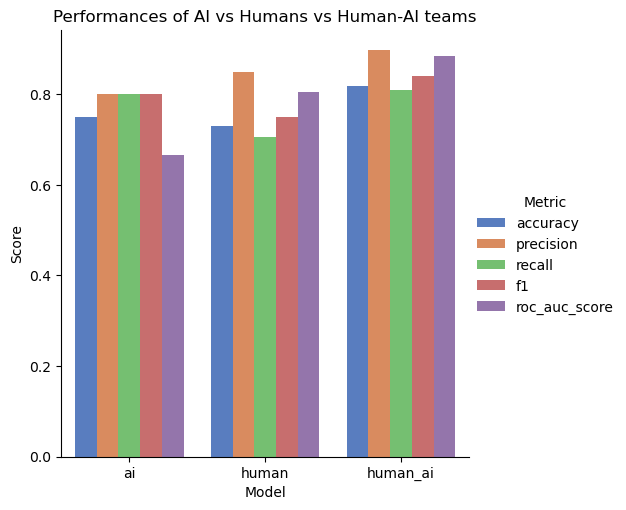

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns

c = sns.catplot(x="variable", y="value", hue="index", data=scores_plot_df,  palette="muted", kind="bar")
plt.title("Performances of AI vs Humans vs Human-AI teams")
plt.ylabel("Score")
plt.xlabel("Model")
c._legend.set_title("Metric")

#### Human vs Human-AI

We use a Wilcoxon signed-rank test to determine if there is a significant difference in participants' performance before and after seeing the AI scores (and explanations).

In [172]:
wilcoxon_test = pg.wilcoxon(df["human_accuracy"], df["human_ai_accuracy"])
highlight(wilcoxon_test)

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,5429.500000,two-sided,0.000000,-0.694207,0.345625


In [173]:
df[["human_accuracy", "human_ai_accuracy"]].describe().loc[["mean", "std"]]

,human_accuracy,human_ai_accuracy
mean,0.730911,0.818350
std,0.158179,0.137579


A significant difference in accuracy before and after seeing the AI score (p < 0.01). The average human accuracy before is 0.730911. The average human accuracy after (= Human-AI accuracy) is 0.818350. (AI accuracy is 0.750000)

#### AI vs Human-AI

We use a Wilcoxon signed-rank test to determine if there is a significant difference between AI performance and Human-AI performance.

In [174]:
ai_accuracy_df = pd.DataFrame({"accuracy": [ai_performance_df["accuracy"][0]] * len(df)})


In [175]:
wilcoxon_test = pg.wilcoxon(ai_accuracy_df["accuracy"], df["human_ai_accuracy"])
highlight(wilcoxon_test)

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,8505.000000,two-sided,0.000000,-0.588415,0.318966


In [176]:
print(f"Mean Human-AI accuracy: {df[['human_ai_accuracy']].mean().values[0]}")
print(f"Mean AI accuracy: {ai_performance_df[['accuracy']].mean().values[0]}")

Mean Human-AI accuracy: 0.8183497536945813
Mean AI accuracy: 0.75


The performance of AI-Human teams is significantly higher than the one of the AI system alone (p < 0.01). The average AI accuracy is 0.750000. The average Human-AI accuracy is 0.818350.

### Compare Human-AI performance among groups (v1 vs v2 vs v3)

We use a Kruskal-Wallis H-test to determine if there is a significant difference in the accuracy of the Human-AI teams among the groups.

In [177]:
kruskal, pairwise, stats = perform_kruskal_with_posthoc(df, "human_ai_accuracy", print_results=False);

In [178]:
highlight(kruskal)

,Source,ddof1,H,p-unc
Kruskal,FEATURE,2,0.320474,0.851942


In [179]:
stats

,count,mean,std
FEATURE,,,
basic,133.0,0.815789,0.132876
explanations,133.0,0.822368,0.150921
salient,140.0,0.816964,0.129341


A high p-value (0.851942) indicates that there is no significant difference in performance among the groups.

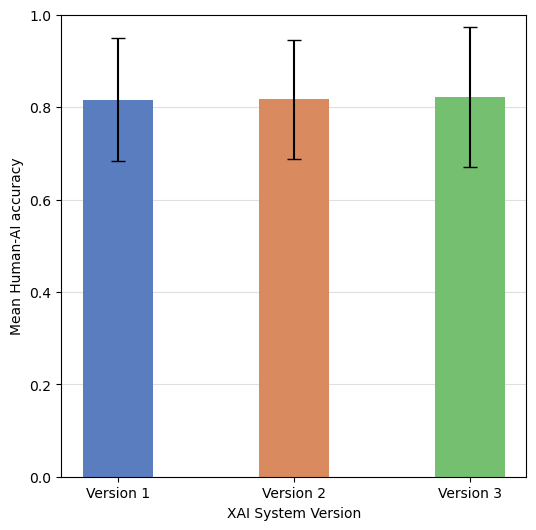

In [180]:
col = "human_ai_accuracy"

accuracy_data = df.groupby("FEATURE")[col].describe()[["mean", "std"]].reset_index()
accuracy_data["FEATURE"] = pd.Categorical(accuracy_data["FEATURE"], categories=["basic", "salient", "explanations"], ordered=True)
accuracy_data = accuracy_data.sort_values("FEATURE")

fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x="FEATURE", y="mean", data=accuracy_data, ax=ax, palette="muted", width=.4)
ax.set_ylabel("Mean Human-AI accuracy")
ax.set_xlabel("XAI System Version")
ax.set_ylim(0, 1)
ax.errorbar(x=accuracy_data["FEATURE"], y=accuracy_data["mean"], yerr=accuracy_data["std"], fmt='none', c='black', capsize=5)
ax.set_xticklabels(["Version 1", "Version 2", "Version 3"])
ax.set_axisbelow(True)
ax.yaxis.grid(True, which='major', color='grey', alpha=.25)

### Compare the change in performance among groups (v1 vs v2 vs v3)

In [181]:
df["accuracy_change"] = df["human_ai_accuracy"] - df["human_accuracy"]

In [182]:
df["accuracy_change"].describe().loc[["count", "mean", "std"]]

count    406.000000
mean       0.087438
std        0.152568
Name: accuracy_change, dtype: float64

On average, the accuracy of the participants increased by 0.087438 after seeing the AI score. We use a Kruskal-Wallis H-test to determine if there is a significant difference in the change in performance of the participants among the groups.

In [183]:
kruskal, pairwise, stats = perform_kruskal_with_posthoc(df, "accuracy_change", print_results=False);

In [184]:
highlight(kruskal)

,Source,ddof1,H,p-unc
Kruskal,FEATURE,2,5.674691,0.058581


In [185]:
stats

,count,mean,std
FEATURE,,,
basic,133.0,0.106203,0.139751
explanations,133.0,0.084586,0.168935
salient,140.0,0.072321,0.146963


There is no significant difference in change in performance among the groups.

## Willingness to adjust judgments to match the AI system

We use three metrics to measure the willingness of the participants to adjust their judgments to match the AI system:
- Agreement percentage: percentage of news items in which the participant’s final prediction agreed with the AI’s prediction (adapted from [1] and [2])
- Switch percentage: percentage of news items in which the participant revised their predictions to match the model’s predictions (adapted from [1] and [2])
- AI-preference: a number between 0 and 1 that indicates the degree to which the participant prefers the AI’s prediction over their own original prediction. This is defined for individual news item ratings of one participant. It is defined as:

$$
ai\_preference = 
\begin{cases}
1 & \text{if } rating_{before} = ai\_rating \text{ and } ai\_rating = rating_{after} \\
0 & \text{if } rating_{before} = ai\_rating \text{ and } ai\_rating \neq rating_{after} \\
\min(1, \max(0, \frac{rating_{after} - rating_{before}}{ai\_rating - rating_{before}})) & \text{otherwise}
\end{cases}
$$

[1]: https://dl.acm.org/doi/10.1145/3290605.3300509 
[2]: https://dl.acm.org/doi/10.1145/3351095.3372852

### Calculate willingness to adjust metrics

In [186]:
def agrees_with_ai(row, newsitem_id):
    ai_rating = newsitems[newsitems["id"] == newsitem_id]["truthfulness"].values[0]
    human_rating = row[f"newsitem.{newsitem_id}.rating-after-xai"]
    return (human_rating < 50) == (ai_rating < 50)

def switched_ratings(row, newsitem_id):
    ai_rating = newsitems[newsitems["id"] == newsitem_id]["truthfulness"].values[0]
    human_rating_before = row[f"newsitem.{newsitem_id}.rating-before-xai"]
    human_rating_after = row[f"newsitem.{newsitem_id}.rating-after-xai"]
    
    return ((human_rating_before < 50) != (human_rating_after < 50)
            ) and ((human_rating_after < 50) == (ai_rating < 50))

def calculate_ai_preference(row, newsitem_id):
    rating_before_col = f"newsitem.{i}.rating-before-xai"
    rating_after_col = f"newsitem.{i}.rating-after-xai"
    ai_rating = newsitems[newsitems["id"] == newsitem_id]["truthfulness"].values[0]

    if row[rating_before_col] == ai_rating:
        if ai_rating == row[rating_after_col]:
            return 1
        else:
            return 0
    else:
        return min(1, max(0, (row[rating_after_col] - row[rating_before_col]) / (ai_rating - row[rating_before_col])))
    
for i in range(7, 15):
    df[f"newsitem.{i}.agrees-with-ai"] = df.apply(lambda row: agrees_with_ai(row, i), axis=1)
    df[f"newsitem.{i}.switched-to-ai"] = df.apply(lambda row: switched_ratings(row, i), axis=1)
    df[f"newsitem.{i}.ai-preference"] = df.apply(lambda row: calculate_ai_preference(row, i), axis=1)

In [187]:
agrees_with_ai_cols = [col for col in df.columns if col.startswith('newsitem') and col.endswith('agrees-with-ai')]
switched_to_ai_cols = [col for col in df.columns if col.startswith('newsitem') and col.endswith('switched-to-ai')]
ai_preference_cols = [col for col in df.columns if col.startswith('newsitem') and col.endswith('ai-preference')]

# calculate average AI preference over all newsitems
df["agrees-with-ai"] = df[agrees_with_ai_cols].mean(axis=1)
df["switched-to-ai"] = df[switched_to_ai_cols].mean(axis=1)
df["ai-preference"] = df[ai_preference_cols].mean(axis=1)

We use Kruskal-Wallis H-tests to determine if there is a significant difference in the willingness of the participants to adjust their judgments among the groups (based on the three metrics). When the test shows a significant difference, we use Mann-Whitney U tests with a Holm correction to determine which groups differ significantly.

### Agreement percentage (v1 vs v2 vs v3)

In [188]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, "agrees-with-ai", print_results=False);

In [189]:
highlight(kruskal)

,Source,ddof1,H,p-unc
Kruskal,FEATURE,2,10.511823,0.005217


In [190]:
highlight(posthoc)

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,cohen
0,FEATURE,basic,explanations,False,False,7219.000000,two-sided,0.006941,0.013883,holm,-0.322320
1,FEATURE,basic,salient,False,False,9418.000000,two-sided,0.864163,0.864163,holm,0.014195
2,FEATURE,explanations,salient,False,False,11140.000000,two-sided,0.003469,0.010407,holm,0.346784


In [191]:
stats

,count,mean,std
FEATURE,,,
basic,133.0,0.736842,0.146182
explanations,133.0,0.781015,0.127258
salient,140.0,0.734821,0.138618


There is a significant difference in **agreement percentage** among the groups (Kruskal-Wallis H-test, p=0.005217), the posthoc tests show that the agreement percentage is significantly higher in v3 than in v1 (Mann-Whitney U test, p=0.013883) or v2 (Mann-Whitney U test, p=0.010407). There is no significant difference between the agreement percentage of groups v1 and v2 (Mann-Whitney U test, p=0.864163).

### Switch percentage (v1 vs v2 vs v3)

In [192]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, "switched-to-ai", print_results=False);

In [193]:
highlight(kruskal)

,Source,ddof1,H,p-unc
Kruskal,FEATURE,2,10.108654,0.006382


In [194]:
highlight(posthoc)

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,cohen
0,FEATURE,basic,explanations,False,False,7899.500000,two-sided,0.123774,0.198357,holm,-0.181541
1,FEATURE,basic,salient,False,False,10357.500000,two-sided,0.099179,0.198357,holm,0.217698
2,FEATURE,explanations,salient,False,False,11323.000000,two-sided,0.001584,0.004753,holm,0.405033


In [195]:
stats

,count,mean,std
FEATURE,,,
basic,133.0,0.223684,0.178809
explanations,133.0,0.256579,0.183554
salient,140.0,0.186607,0.161836


There is a significant difference in **switch percentage** among the groups (Kruskal-Wallis H-test, p=0.006382), the posthoc tests show that switch percentage is significantly higher in v3 than in v2 (Mann-Whitney U test, p=0.004753). There is no significant difference between the switch percentage of groups v1 and v2 (Mann-Whitney U test, p=0.198357) or v1 and v3 (Mann-Whitney U test, p=0.198357).

### AI-preference (v1 vs v2 vs v3)

In [196]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, "ai-preference", print_results=False);

In [197]:
highlight(kruskal)

,Source,ddof1,H,p-unc
Kruskal,FEATURE,2,18.061552,0.000120


In [198]:
highlight(posthoc)

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,cohen
0,FEATURE,basic,explanations,False,False,7104.000000,two-sided,0.005545,0.011090,holm,-0.326000
1,FEATURE,basic,salient,False,False,10309.500000,two-sided,0.125494,0.125494,holm,0.160694
2,FEATURE,explanations,salient,False,False,11998.000000,two-sided,0.000038,0.000113,holm,0.484023


In [199]:
stats

,count,mean,std
FEATURE,,,
basic,133.0,0.509299,0.205499
explanations,133.0,0.576165,0.204720
salient,140.0,0.475976,0.209125


There is a significant difference in **AI-preference** among the groups (Kruskal-Wallis H-test, p=0.00012), the posthoc tests show that AI-preference is significantly higher in v3 than in v1 (Mann-Whitney U test, p=0.011090) or v2 (Mann-Whitney U test, p=0.000113). There is no significant difference between the AI-preference of groups v1 and v2 (Mann-Whitney U test, p=0.125494).

In [200]:
pg.cronbach_alpha(df[["agrees-with-ai", "switched-to-ai", "ai-preference"]])

(0.8186625030487245, array([0.786, 0.847]))

As the three metrics aim to measure similar concepts, we calculate Cronbach's alpha to determine if the metrics are consistent. The Cronbach's alpha is 0.818663, which indicates that the metrics are consistent.

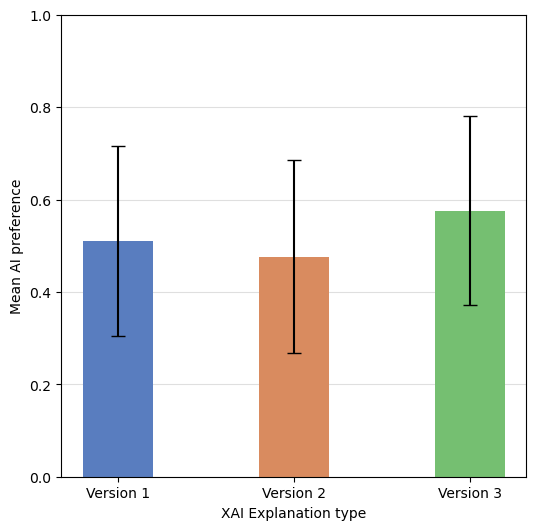

In [201]:
ai_pref_data = df.groupby("FEATURE")["ai-preference"].describe()[["mean", "std"]].reset_index()
ai_pref_data["FEATURE"] = pd.Categorical(ai_pref_data["FEATURE"], categories=["basic", "salient", "explanations"], ordered=True)
ai_pref_data = ai_pref_data.sort_values("FEATURE")

fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x="FEATURE", y="mean", data=ai_pref_data, ax=ax, palette="muted", width=.4)
ax.set_ylabel("Mean AI preference")
ax.set_xlabel("XAI Explanation type")
ax.set_ylim(0, 1)
ax.errorbar(x=ai_pref_data["FEATURE"], y=ai_pref_data["mean"], yerr=ai_pref_data["std"], fmt='none', c='black', capsize=5)
ax.set_xticklabels(["Version 1", "Version 2", "Version 3"])
ax.set_axisbelow(True)
ax.yaxis.grid(True, which='major', color='grey', alpha=.25)

## Effects of mistakes of the system

The experiment was designed to intentionally include mistakes of the AI system. We want to investigate if the participants are able to detect these mistakes, if they are willing to adjust their judgments to match the AI system and how they rate the AI-system when looking at the mistakes.

Both types of mistakes of binary classification are included in the experiment:
- **False positive**: the AI system predicts a news item to be fake, while it is actually truthful (newsitem 14)
- **False negative**: the AI system predicts a news item to be truthful, while it is actually fake (newsitem 13)

In [202]:
def get_mistake_type(row):
  if (row["is_fake_news"] == False) & (row["is_fake_news_pred"] == True):
    return "FP"
  elif (row["is_fake_news"] == True) & (row["is_fake_news_pred"] == False):
    return "FN"
  elif row["is_fake_news"]:
    return "TP"
  else:
    return "TN"

newsitems["is_mistake"] = newsitems["is_fake_news"] != newsitems["is_fake_news_pred"]
newsitems["mistake_type"] = newsitems.apply(get_mistake_type, axis=1)

In [203]:
def get_newsitem_cetagory(row):
    # assign clearly true, rather fake, clearly fake, or falsely labeled to each newsitem
    if row["is_mistake"] == True:
        return "falsely labeled"
    elif row["truthfulness"] < 25:
        return "clearly fake"
    elif row["truthfulness"] < 50:
        return "rather fake"
    elif row["truthfulness"] < 75:
        return "rather true"
    else:
        return "clearly true"
    
newsitems["newsitem_category"] = newsitems.apply(get_newsitem_cetagory, axis=1)

In [204]:
pd.set_option('display.max_colwidth', 200)

newsitems[(newsitems["id"] == 13) | (newsitems["id"] == 14)][[
    "title", "subtitle", "content", 
    "truthfulness", "is_fake_news", "is_fake_news_pred", 
    "is_mistake", "mistake_type"]
]

,title,subtitle,content,truthfulness,is_fake_news,is_fake_news_pred,is_mistake,mistake_type
13,JOE BIDEN SAYS BIBLE BELIEVING CHRISTIANS VIOLATE LGBT RIGHTS BY SIMPLY EXISTING,"In too many places, Joe Biden said today, LGBT community members face violence with impunity, mistreatment by police, the denial of healthcare, or religious condemnation and social isolation....\n",Vice President Joe Biden say today that the rights of the LGBT people are violated by “religious condemnation”. He is directly referring to Bible verses. The Progressive Liberals are well aware th...,97,True,False,True,FN
14,"Boys need to talk more about feelings and fight inequality, report says",The Global Boyhood Initiative aims to enable adults to raise boys to become men who embrace healthy masculinity\r\n,"Boys should be encouraged to ignore gender stereotypes and share their emotions, according to the team behind a new UK initiative aimed at encouraging them to talk about their feelings and speak o...",10,False,True,True,FP


In [205]:
newsitem_eval_df = pd.DataFrame()

for i in range(7, 15):
    newsitem_cols = [
                     f"newsitem.{i}.system-evaluation.classified-correctly",
                     f"newsitem.{i}.system-evaluation.explanations-comprehensible-and-help-assess",
                     f"newsitem.{i}.system-evaluation.indications-useful",
                     f"newsitem.{i}.system-evaluation.understand-what-system-does",
                     f"newsitem.{i}.system-evaluation.xai-features-useful",
                     f"newsitem.{i}.rating-before-correct",
                     f"newsitem.{i}.rating-after-correct",
                     f"newsitem.{i}.agrees-with-ai",
                     f"newsitem.{i}.switched-to-ai",
                     f"newsitem.{i}.ai-preference",
                     "FEATURE"
                    ]
    newsitem_eval_df = pd.concat([newsitem_eval_df, df[newsitem_cols].rename(columns={col: col.split(".")[-1] for col in newsitem_cols}).assign(newsitem=i)])

# make "newsitem" the first column
cols = newsitem_eval_df.columns.tolist()
cols = cols[-2:] + cols[:-2]
newsitem_eval_df = newsitem_eval_df[cols]

In [206]:
# join newsitem_eval_df with newsitems to get the "is_mistake" column
newsitem_eval_df = newsitem_eval_df.merge(
  newsitems[["id", "is_fake_news", "is_mistake", "mistake_type", "newsitem_category"]], 
  left_on="newsitem", 
  right_on="id").drop(columns=["id"])

Measures:
- on newsitem level: accuracy, change in accuracy, agreement percentage, switch percentage
- on single rating level: ai-preference, local evaluation metrics

In [207]:
newsitem_eval_df.sample(5, random_state=42)

,FEATURE,newsitem,classified-correctly,explanations-comprehensible-and-help-assess,indications-useful,understand-what-system-does,xai-features-useful,rating-before-correct,rating-after-correct,agrees-with-ai,switched-to-ai,ai-preference,is_fake_news,is_mistake,mistake_type,newsitem_category
1905,explanations,11,7.0,7.0,7.0,6.0,7.0,False,True,True,True,0.888889,True,False,TP,clearly fake
1815,salient,11,6.0,6.0,6.0,6.0,6.0,True,True,True,False,0.000000,True,False,TP,clearly fake
2004,explanations,11,7.0,7.0,7.0,6.0,7.0,True,True,True,False,0.833333,True,False,TP,clearly fake
321,explanations,7,7.0,7.0,7.0,7.0,7.0,True,True,True,False,1.000000,False,False,TN,clearly true
2847,basic,14,2.0,1.0,3.0,4.0,2.0,True,False,True,True,0.173913,False,True,FP,falsely labeled


### Is rating the newsitems equally difficult?

We use a chi-squared test to determine if there is a significant difference in correct and incorrect ratings among the news item groups (clearly true, rather fake, clearly fake, and falsely labeled). We look at ratings before seeing the AI score. 

In [208]:
# perform chi2 test
expected, observed, stats = pg.chi2_independence(newsitem_eval_df, x='newsitem_category', y='rating-before-correct')

In [209]:
highlight(stats)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,298.656447,3.000000,0.000000,0.303234,1.000000
1,cressie-read,0.666667,292.448945,3.000000,0.000000,0.300066,1.000000
2,log-likelihood,0.000000,288.417637,3.000000,0.000000,0.297991,1.000000
3,freeman-tukey,-0.500000,292.414755,3.000000,0.000000,0.300049,1.000000
4,mod-log-likelihood,-1.000000,302.522032,3.000000,0.000000,0.305190,1.000000
5,neyman,-2.000000,343.356738,3.000000,0.000000,0.325136,1.000000


The low p values (<0.01) show us that the newsitems are unequally difficult to rate.

### Accuracy on newsitems before and after seeing the AI score

In [210]:
# calculate average performance over newsitems
performance_df = newsitem_eval_df.groupby(["newsitem_category"])[["rating-before-correct", "rating-after-correct"]].mean().reset_index()

In [211]:
performance_df["accuracy-diff"] = performance_df["rating-after-correct"] - performance_df["rating-before-correct"]

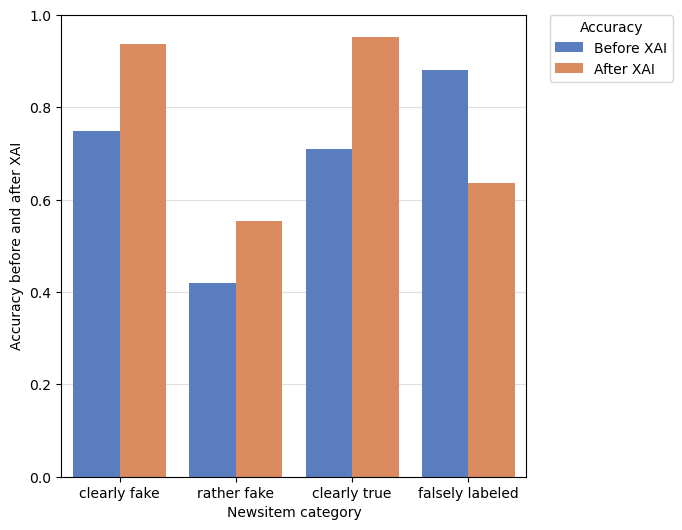

In [268]:
# transform data to long format
data = performance_df[["newsitem_category", "rating-before-correct", "rating-after-correct"]].melt(id_vars=["newsitem_category"], var_name="measure", value_name="rating")

fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x="newsitem_category", y="rating", 
  hue="measure", 
  data=data, 
  ax=ax, 
  palette="muted",
  order=["clearly fake", "rather fake", "clearly true", "falsely labeled"]
  )

# rename legend labels
handles, labels = ax.get_legend_handles_labels()
# put legend outside of plot
ax.legend(handles=handles, labels=["Before XAI", "After XAI"], title="Accuracy", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


ax.set_ylabel("Accuracy before and after XAI")
ax.set_xlabel("Newsitem category")

ax.set_axisbelow(True)
ax.yaxis.grid(True, which='major', color='grey', alpha=.25)


The graph shows that in the case of all newsitem categories, the accuracy of the participants increased after seeing the AI score, except for the system mistakes where it decreased.

Next we look at the change in accuracy.

In [213]:
performance_df

,newsitem_category,rating-before-correct,rating-after-correct,accuracy-diff
0,clearly fake,0.747947,0.938424,0.190476
1,clearly true,0.710591,0.953202,0.242611
2,falsely labeled,0.881773,0.635468,-0.246305
3,rather fake,0.418719,0.554187,0.135468


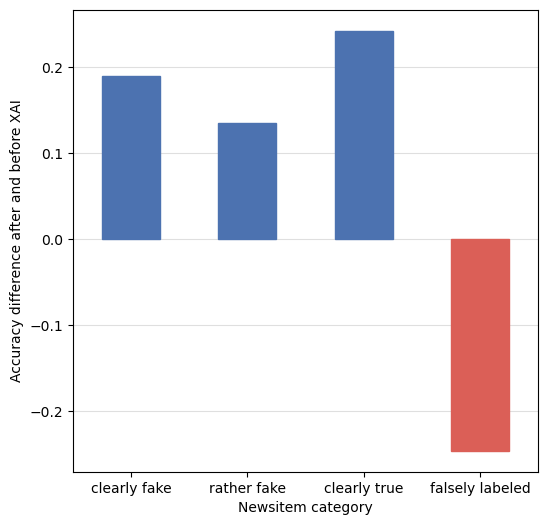

In [270]:
blue = "#4C72B0"
red = "#DB5F57"

fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x="newsitem_category", y="accuracy-diff", data=performance_df, ax=ax, palette="muted", width=.5,
            order=["clearly fake", "rather fake", "clearly true", "falsely labeled"])
ax.set_ylabel("Accuracy difference after and before XAI")
ax.set_xlabel("Newsitem category")

# set the colors of the bars based on their value
for i, bar in enumerate(ax.patches):
  if bar.get_height() > 0:
    bar.set_color(blue)
  else:
    bar.set_color(red)

ax.set_axisbelow(True)
ax.yaxis.grid(True, which='major', color='grey', alpha=.25)


We perform a chi-squared test to determine if there is a significant difference in the number of correct and incorrect ratings among the news items after seeing the AI score among newsitem categories.

In [215]:
# perform chi2 test
expected, observed, stats = pg.chi2_independence(newsitem_eval_df, x='newsitem_category', y='rating-after-correct')

In [216]:
highlight(stats)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,590.746543,3.000000,0.000000,0.426474,1.000000
1,cressie-read,0.666667,580.741194,3.000000,0.000000,0.422847,1.000000
2,log-likelihood,0.000000,584.692022,3.000000,0.000000,0.424283,1.000000
3,freeman-tukey,-0.500000,610.534348,3.000000,0.000000,0.433558,1.000000
4,mod-log-likelihood,-1.000000,660.385614,3.000000,0.000000,0.450911,1.000000
5,neyman,-2.000000,866.835097,3.000000,0.000000,0.516607,1.000000


In [217]:
newsitem_eval_df.groupby("newsitem_category")["rating-after-correct"].mean()

newsitem_category
clearly fake       0.938424
clearly true       0.953202
falsely labeled    0.635468
rather fake        0.554187
Name: rating-after-correct, dtype: float64

### AI-preference on newsitems

In [218]:
ai_preference_means = newsitem_eval_df.groupby("newsitem_category")["ai-preference"].mean().reset_index()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

clearly fake vs. rather fake: Mann-Whitney-Wilcoxon test two-sided, P_val:1.899e-01 U_stat=2.578e+05
rather fake vs. clearly true: Mann-Whitney-Wilcoxon test two-sided, P_val:2.282e-08 U_stat=1.329e+05
clearly true vs. falsely labeled: Mann-Whitney-Wilcoxon test two-sided, P_val:1.035e-72 U_stat=4.987e+05
clearly fake vs. clearly true: Mann-Whitney-Wilcoxon test two-sided, P_val:1.247e-06 U_stat=4.329e+05
rather fake vs. falsely labeled: Mann-Whitney-Wilcoxon test two-sided, P_val:6.929e-21 U_stat=2.184e+05
clearly fake vs. falsely labeled: Mann-Whitney-Wilcoxon test two-sided, P_val:4.266e-34 U_stat=6.495e+05


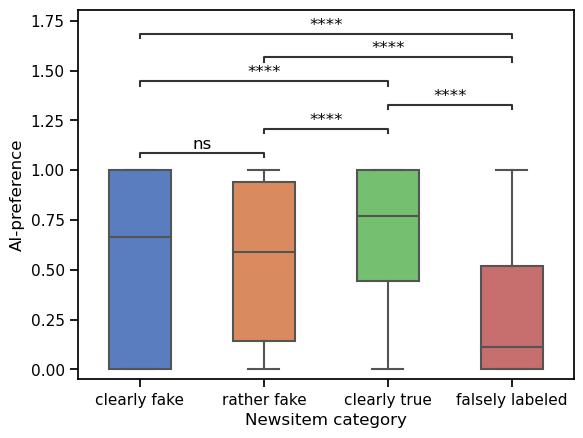

In [219]:
from itertools import combinations
from statannotations.Annotator import Annotator

values = ["clearly fake", "rather fake", "clearly true", "falsely labeled"]
pairs = list(combinations(values, 2))

plot_params = {
  "x": "newsitem_category", 
  "y": "ai-preference", 
  "data": newsitem_eval_df, 
  "palette": "muted",
  "width": .5, 
  "order": ["clearly fake", "rather fake", "clearly true", "falsely labeled"]
}

with sns.plotting_context('notebook'):
    ax = sns.boxplot()

    sns.boxplot(**plot_params).set(xlabel='Newsitem category', ylabel='AI-preference')

    # Add annotations
    annotator = Annotator(ax, pairs, **plot_params)
    annotator.configure(test='Mann-Whitney')
    annotator.apply_test().annotate()

    plt.show()

In [220]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(newsitem_eval_df, dv="ai-preference", between="newsitem_category", print_results=False)

In [221]:
highlight(kruskal)

,Source,ddof1,H,p-unc
Kruskal,newsitem_category,3,314.548342,0.000000


In [222]:
highlight(posthoc)

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,cohen
0,newsitem_category,clearly fake,clearly true,False,False,432855.000000,two-sided,0.000001,0.000002,holm,-0.282842
1,newsitem_category,clearly fake,falsely labeled,False,False,649526.500000,two-sided,0.000000,0.000000,holm,0.661657
2,newsitem_category,clearly fake,rather fake,False,False,257784.000000,two-sided,0.189900,0.189900,holm,0.056910
3,newsitem_category,clearly true,falsely labeled,False,False,498716.000000,two-sided,0.000000,0.000000,holm,1.050107
4,newsitem_category,clearly true,rather fake,False,False,196803.000000,two-sided,0.000000,0.000000,holm,0.371953
5,newsitem_category,falsely labeled,rather fake,False,False,111231.000000,two-sided,0.000000,0.000000,holm,-0.645009


### Which participants can detect the mistakes of the system?

The ability to detect mistakes of the system is measured using two metrics:
- **AI preference at mistakes**: average AI-preference of the participants on the two newsitems where the AI made a mistake (the lower the AI-preference, the better the participant is able to detect mistakes)
- **Number of mistakes corrected**: the number of newsitems where the participant's second rating corrects the mistake of the AI (the higher the number, the better the participant is able to detect the mistakes)

In [223]:
df["mistake-ai-preference"] = np.mean([
    df["newsitem.13.ai-preference"], 
    df["newsitem.14.ai-preference"]
], axis=0)

In [224]:
df["fixed-mistakes-count"] = 2 - np.sum([
    df["newsitem.13.agrees-with-ai"],
    df["newsitem.14.agrees-with-ai"]
], axis=0)

In [225]:
relevant_demographics_cols = [
    'demographics.age',
    'demographics.education',
    'demographics.employment',
    'demographics.gender',
    'demographics.income'
]

#### Demographics

In [226]:
summary_df = pd.DataFrame()

for demo_col in relevant_demographics_cols:
    kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, dv="mistake-ai-preference", between=demo_col, print_results=False)

    # reset index of kruskal dataframe
    kruskal = kruskal.reset_index(drop=True)

    summary_df = pd.concat([summary_df, kruskal])
    
summary_df = summary_df.reset_index(drop=True)
summary_df = summary_df.sort_values("p-unc")

highlight(summary_df)


,Source,ddof1,H,p-unc
4,demographics.income,6,11.850651,0.065385
1,demographics.education,4,8.730502,0.068200
3,demographics.gender,2,1.576807,0.454570
2,demographics.employment,7,4.706767,0.695697
0,demographics.age,5,0.814808,0.976079


In [227]:
summary_df = pd.DataFrame()

for demo_col in relevant_demographics_cols:
    kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, dv="fixed-mistakes-count", between=demo_col, print_results=False)

    # reset index of kruskal dataframe
    kruskal = kruskal.reset_index(drop=True)

    summary_df = pd.concat([summary_df, kruskal])
    
summary_df = summary_df.reset_index(drop=True)
summary_df = summary_df.sort_values("p-unc")

highlight(summary_df)

,Source,ddof1,H,p-unc
1,demographics.education,4,8.611683,0.071573
4,demographics.income,6,11.502886,0.074023
2,demographics.employment,7,5.358297,0.616326
3,demographics.gender,2,0.528382,0.767827
0,demographics.age,5,0.610386,0.987523


There are no significant differences between demographic groups in the ability to detect mistakes of the system (p > 0.05). However, education level and income level show a trend towards significance (p = 0.068200 and p = 0.065385 respectively). Higher education level and higher income level are associated with a higher ability to detect mistakes of the system.

##### Education

In [228]:
df.groupby("demographics.education")["mistake-ai-preference"].describe()[["count", "mean", "std"]]

,count,mean,std
demographics.education,,,
high-school,161.0,0.330980,0.327710
no-degree,11.0,0.462061,0.334240
secondary,9.0,0.524797,0.417951
university,220.0,0.263080,0.286942
upper-secondary,5.0,0.251384,0.386703


In [229]:
df["education-level"] = df["demographics.education"].map({
    "no-degree": 0,
    "secondary": 1,
    "upper-secondary": 2,
    "high-school": 3,
    "university": 4
})

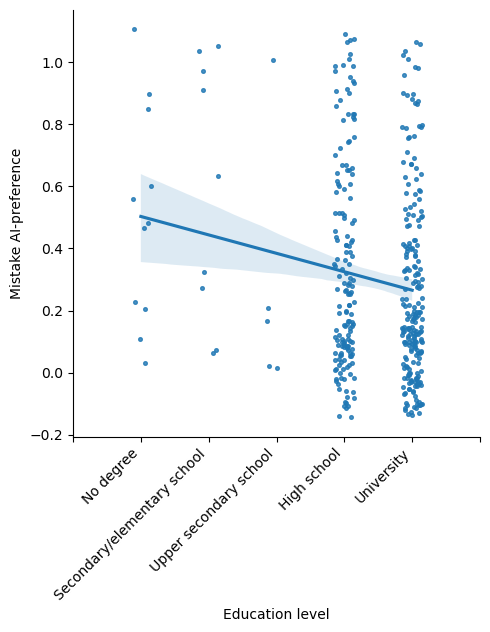

In [230]:
fig = sns.lmplot(
    data=df, 
    x="education-level", 
    y="mistake-ai-preference",
    x_jitter=.15, y_jitter=.15,
    scatter_kws={"s":7}, legend=False)

ticks = [
    "",
    "No degree",
    "Secondary/elementary school",
    "Upper secondary school",
    "High school",
    "University",
    ""
]

fig.set_xticklabels(ticks, rotation=45, ha="right")

fig.set_axis_labels("Education level", "Mistake AI-preference");

In [231]:
pg.corr(x=df["education-level"], y=df["mistake-ai-preference"], method="spearman")

,n,r,CI95%,p-val,power
spearman,406,-0.123301,"[-0.22, -0.03]",0.012909,0.702178


##### Income

In [232]:
df.groupby("demographics.income")["mistake-ai-preference"].describe()[["count", "mean", "std"]]

,count,mean,std
demographics.income,,,
20000-34999-usd,72.0,0.325235,0.322903
35000-49999-usd,44.0,0.338801,0.291346
50000-74999-usd,83.0,0.336189,0.315756
75000-99999-usd,49.0,0.268004,0.291580
less-than-20000-usd,58.0,0.357099,0.355623
no-answer,45.0,0.255913,0.314950
over-100000-usd,55.0,0.193459,0.253968


In [233]:
df["income-level"] = df["demographics.income"].map({
    "less-than-20000-usd": 0,
    "20000-34999-usd": 1,
    "35000-49999-usd": 2,
    "50000-74999-usd": 3,
    "75000-99999-usd": 4,
    "over-100000-usd": 5,
    # no-answer is mapped to NaN, which is ignored by seaborn
})

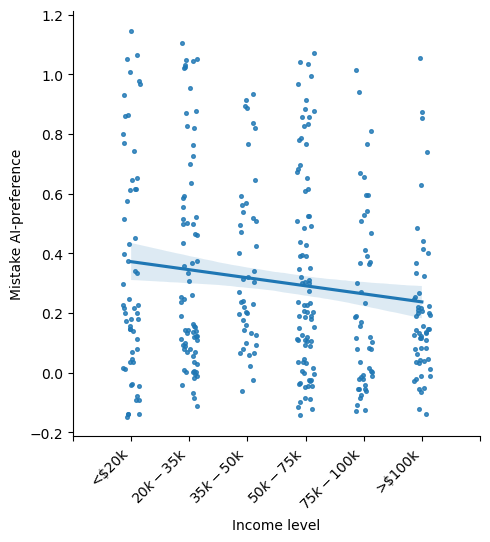

In [234]:
fig = sns.lmplot(
    data=df, 
    x="income-level", 
    y="mistake-ai-preference",
    x_jitter=.15, y_jitter=.15,
    scatter_kws={"s":7}, legend=False)

# set xticks
ticks = [
    "", # add an empty label for the extra tick
    "<$20k",
    "$20k-$35k",
    "$35k-$50k",
    "$50k-$75k",
    "$75k-$100k",
    ">$100k",
    ""  # add another empty label for the extra tick
]

fig.set_xticklabels(ticks, rotation=45, ha="right")


fig.set_axis_labels("Income level", "Mistake AI-preference");

In [235]:
pg.corr(x=df["income-level"], y=df["mistake-ai-preference"], method="spearman")

,n,r,CI95%,p-val,power
spearman,361,-0.12659,"[-0.23, -0.02]",0.016104,0.674045


#### Information literacy

In [236]:
information_literacy_cols = [col for col in df.columns if "information-literacy." in col]
pg.cronbach_alpha(df[information_literacy_cols])

(0.9001577165376676, array([0.885, 0.914]))

In [237]:
df["information-literacy"] = np.sum(df[information_literacy_cols], axis=1)

In [238]:
pairwise_corr = pg.pairwise_corr(df, ["mistake-ai-preference", "fixed-mistakes-count", "information-literacy", "human_accuracy"])

In [239]:
highlight(pairwise_corr)

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,mistake-ai-preference,fixed-mistakes-count,pearson,two-sided,406,-0.868800,[-0.89 -0.84],0.000000,3.221e+121,1.000000
1,mistake-ai-preference,information-literacy,pearson,two-sided,406,-0.071813,[-0.17 0.03],0.148626,0.176,0.303817
2,mistake-ai-preference,human_accuracy,pearson,two-sided,406,-0.310534,[-0.4 -0.22],0.000000,4.424e+07,0.999997
3,fixed-mistakes-count,information-literacy,pearson,two-sided,406,0.072170,[-0.03 0.17],0.146614,0.178,0.306333
4,fixed-mistakes-count,human_accuracy,pearson,two-sided,406,0.367405,[0.28 0.45],0.000000,2.835e+11,1.000000
5,information-literacy,human_accuracy,pearson,two-sided,406,0.022694,[-0.07 0.12],0.648446,0.069,0.074115


Information literacy does not seem to play a role in detecting the mistakes. Moderate correlation between accuracy without AI ratings and ability to detect mistakes.

### Detecting mistakes among groups

In [240]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, dv="mistake-ai-preference", between="FEATURE", print_results=False)

In [241]:
highlight(kruskal)

,Source,ddof1,H,p-unc
Kruskal,FEATURE,2,6.496020,0.038851


In [242]:
highlight(posthoc)

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,cohen
0,FEATURE,basic,explanations,False,False,7683.500000,two-sided,0.063911,0.127823,holm,-0.235669
1,FEATURE,basic,salient,False,False,9764.000000,two-sided,0.485130,0.485130,holm,0.043064
2,FEATURE,explanations,salient,False,False,10879.000000,two-sided,0.015925,0.047775,holm,0.274848


In [243]:
stats

,count,mean,std
FEATURE,,,
basic,133.0,0.281200,0.297582
explanations,133.0,0.355423,0.331407
salient,140.0,0.268266,0.302910


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

basic vs. salient: Mann-Whitney-Wilcoxon test two-sided, P_val:4.851e-01 U_stat=9.764e+03
salient vs. explanations: Mann-Whitney-Wilcoxon test two-sided, P_val:1.593e-02 U_stat=7.741e+03
basic vs. explanations: Mann-Whitney-Wilcoxon test two-sided, P_val:6.391e-02 U_stat=7.684e+03


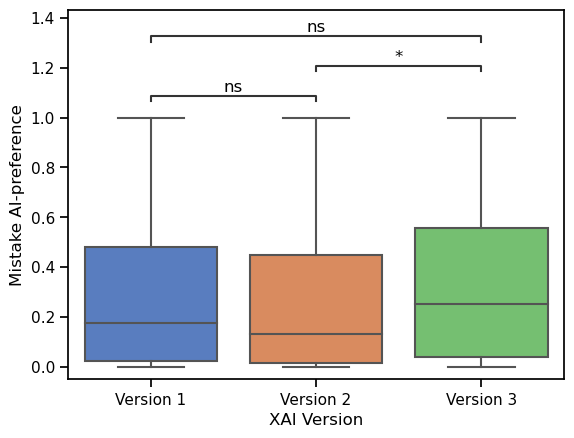

In [249]:
from statannotations.Annotator import Annotator
from itertools import combinations

values = ["basic", "salient", "explanations"]
pairs = list(combinations(values, 2))

plot_params = {
  'data': df,
  'x': 'FEATURE',
  'y': 'mistake-ai-preference',
  'palette': 'muted'
}

with sns.plotting_context('notebook'):
    ax = sns.boxplot()

    sns.boxplot(**plot_params).set(xlabel='XAI Version', ylabel='Mistake AI-preference')

    # rename basic, salient, explanations to be Version 1, Version 2, Version 3
    ax.set_xticklabels(["Version 1", "Version 2", "Version 3"])

    # Add annotations
    annotator = Annotator(ax, pairs, **plot_params)
    annotator.configure(test='Mann-Whitney')
    annotator.apply_test().annotate()

    plt.show()

Participants using Version 3 were most likely to trust the AI in case of mistakes, however they are also the most likely to trust AI in general. This might needs further testing.

### Local evaluation of newsitems

In [245]:
# TODO: Rewrite to use newsitem categories instead of individual newsitems

In [246]:
local_eval_cols = [
    'classified-correctly', # The AI-System classified the news items correctly
    'explanations-comprehensible-and-help-assess', # The presented explanations are comprehensible and help me with assessing the news articles
    'indications-useful', # The indications given by the AI-System are useful to assess the truthfulness of the news article
    'understand-what-system-does', # I understand what the AI-System does
    'xai-features-useful' # The explainability features presented are useful to assess the truthfulness of the news article
]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

clearly fake vs. rather fake: Mann-Whitney-Wilcoxon test two-sided, P_val:1.493e-13 U_stat=3.032e+05
rather fake vs. clearly true: Mann-Whitney-Wilcoxon test two-sided, P_val:5.013e-12 U_stat=1.276e+05
clearly true vs. falsely labeled: Mann-Whitney-Wilcoxon test two-sided, P_val:3.253e-101 U_stat=5.254e+05
clearly fake vs. clearly true: Mann-Whitney-Wilcoxon test two-sided, P_val:4.471e-01 U_stat=5.034e+05
rather fake vs. falsely labeled: Mann-Whitney-Wilcoxon test two-sided, P_val:1.464e-41 U_stat=2.418e+05
clearly fake vs. falsely labeled: Mann-Whitney-Wilcoxon test two-sided, P_val:1.357e-118 U_stat=7.824e+05


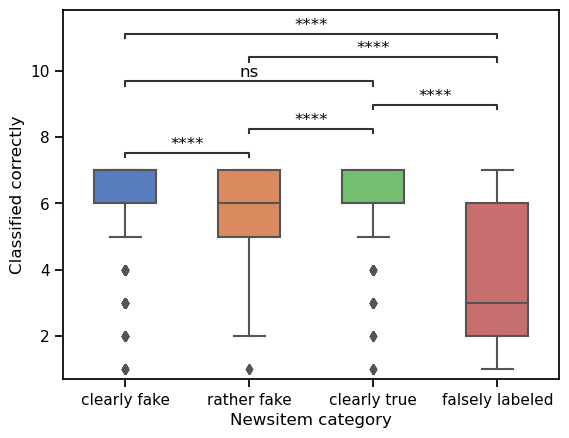

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

clearly fake vs. rather fake: Mann-Whitney-Wilcoxon test two-sided, P_val:1.425e-03 U_stat=2.714e+05
rather fake vs. clearly true: Mann-Whitney-Wilcoxon test two-sided, P_val:2.230e-02 U_stat=1.525e+05
clearly true vs. falsely labeled: Mann-Whitney-Wilcoxon test two-sided, P_val:2.700e-29 U_stat=4.311e+05
clearly fake vs. clearly true: Mann-Whitney-Wilcoxon test two-sided, P_val:3.043e-01 U_stat=5.067e+05
rather fake vs. falsely labeled: Mann-Whitney-Wilcoxon test two-sided, P_val:1.627e-12 U_stat=2.043e+05
clearly fake vs. falsely labeled: Mann-Whitney-Wilcoxon test two-sided, P_val:6.678e-39 U_stat=6.544e+05


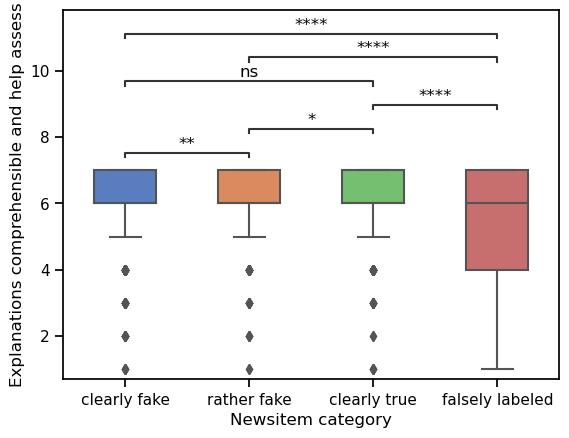

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

clearly fake vs. rather fake: Mann-Whitney-Wilcoxon test two-sided, P_val:8.096e-04 U_stat=2.728e+05
rather fake vs. clearly true: Mann-Whitney-Wilcoxon test two-sided, P_val:8.578e-03 U_stat=1.506e+05
clearly true vs. falsely labeled: Mann-Whitney-Wilcoxon test two-sided, P_val:1.610e-42 U_stat=4.542e+05
clearly fake vs. clearly true: Mann-Whitney-Wilcoxon test two-sided, P_val:3.867e-01 U_stat=5.049e+05
rather fake vs. falsely labeled: Mann-Whitney-Wilcoxon test two-sided, P_val:2.014e-19 U_stat=2.157e+05
clearly fake vs. falsely labeled: Mann-Whitney-Wilcoxon test two-sided, P_val:2.793e-53 U_stat=6.849e+05


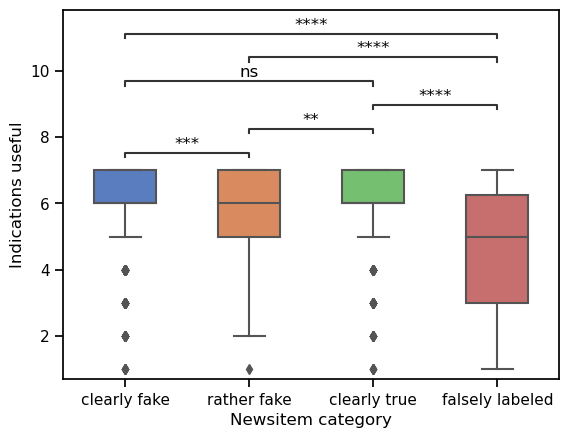

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

clearly fake vs. rather fake: Mann-Whitney-Wilcoxon test two-sided, P_val:2.035e-01 U_stat=2.567e+05
rather fake vs. clearly true: Mann-Whitney-Wilcoxon test two-sided, P_val:2.871e-01 U_stat=1.592e+05
clearly true vs. falsely labeled: Mann-Whitney-Wilcoxon test two-sided, P_val:3.332e-12 U_stat=3.908e+05
clearly fake vs. clearly true: Mann-Whitney-Wilcoxon test two-sided, P_val:8.405e-01 U_stat=4.969e+05
rather fake vs. falsely labeled: Mann-Whitney-Wilcoxon test two-sided, P_val:4.996e-06 U_stat=1.897e+05
clearly fake vs. falsely labeled: Mann-Whitney-Wilcoxon test two-sided, P_val:6.973e-15 U_stat=5.876e+05


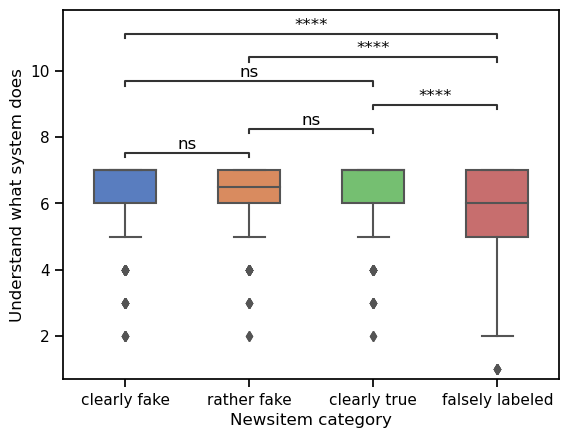

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

clearly fake vs. rather fake: Mann-Whitney-Wilcoxon test two-sided, P_val:1.461e-02 U_stat=2.658e+05
rather fake vs. clearly true: Mann-Whitney-Wilcoxon test two-sided, P_val:1.655e-02 U_stat=1.519e+05
clearly true vs. falsely labeled: Mann-Whitney-Wilcoxon test two-sided, P_val:1.538e-27 U_stat=4.278e+05
clearly fake vs. clearly true: Mann-Whitney-Wilcoxon test two-sided, P_val:9.311e-01 U_stat=4.935e+05
rather fake vs. falsely labeled: Mann-Whitney-Wilcoxon test two-sided, P_val:5.508e-12 U_stat=2.034e+05
clearly fake vs. falsely labeled: Mann-Whitney-Wilcoxon test two-sided, P_val:2.813e-32 U_stat=6.399e+05


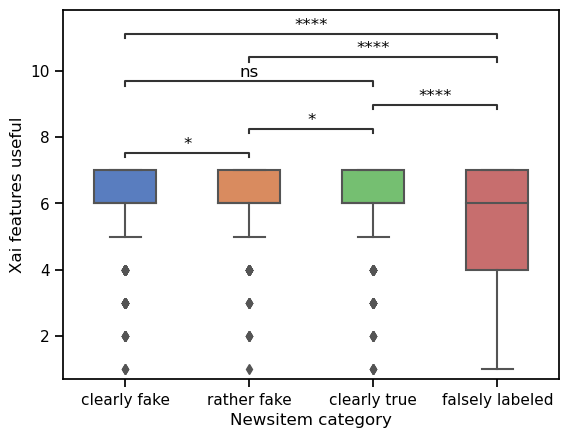

In [257]:
from itertools import combinations
from statannotations.Annotator import Annotator

for local_eval_col in local_eval_cols:

    values = ["clearly fake", "rather fake", "clearly true", "falsely labeled"]
    pairs = list(combinations(values, 2))

    plot_params = {
      "x": "newsitem_category", 
      "y": local_eval_col, 
      "data": newsitem_eval_df, 
      "palette": "muted",
      "width": .5, 
      "order": values
    }

    with sns.plotting_context('notebook'):
        ax = sns.boxplot()

        ylabel = local_eval_col.replace("-", " ").capitalize()
        sns.boxplot(**plot_params).set(xlabel='Newsitem category', ylabel=ylabel)

        # Add annotations
        annotator = Annotator(ax, pairs, **plot_params)
        annotator.configure(test='Mann-Whitney')
        annotator.apply_test().annotate()

        plt.show()

In [258]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(newsitem_eval_df, dv="classified-correctly", between="newsitem_category", print_results=False)

In [267]:
summary_data = []

for col in local_eval_cols:
    kruskal, posthoc, stats = perform_kruskal_with_posthoc(newsitem_eval_df, dv=col, between="newsitem_category", print_results=False)
    summary_data.append({
        "measure": col,
        "H": kruskal["H"].values[0],
        "p-unc": kruskal["p-unc"].values[0],
    })

summary_df = pd.DataFrame(summary_data)
highlight(summary_df)

,measure,H,p-unc
0,classified-correctly,692.225495,0.000000
1,explanations-comprehensible-and-help-assess,199.967566,0.000000
2,indications-useful,286.207598,0.000000
3,understand-what-system-does,72.624259,0.000000
4,xai-features-useful,172.921698,0.000000


All local evaluation metrics are significanly lower for the newsitems where the AI made a mistake than for the newsitems in other categories (p < 0.01). This indicates that the participants are able to detect the mistakes of the system.

Key takeaways:
- Participants could detect the mistakes of the system (lower local evaluation metrics, lower AI-preference)
- AI mistakes still had a negative effect on the accuracy of the participants (Human-AI accuracy for mistakes is lower than Human accuracy)
- Education level and income level are associated with a higher ability to detect mistakes of the system, but the effect is not significant
- Information literacy does not seem to play a role in detecting the mistakes

## Analysis of open questions

The questionnaire includes three open questions, one about the participants' usual criteria for judging the trustworthiness of news items (*"What criteria do you usually use to judge whether a news/article is reliable?"*) and two questions about additional information or functionality they wish to see in the system to improve it (*"What functionality would be a good addition?"*; *"What other information would you like to obtain to better assess the truthfulness of an article?"*).

In addition to reading the answers to these questions, the answers were also analyzed by determining the 50 most common words in the answers. (To count the words the base forms of the words were used, using the spaCy library.)

In [ ]:
criteria_col = "ai-system-evaluation.criteria-to-judge-reliability"
add_func_col = "ai-system-evaluation.additional-functionality"
other_info_col = "ai-system-evaluation.other-information-wish"

### NLP determining lemma frequencies

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

def lemmas_present(row, col, word_counts):
    text = row[col]
    text = str(text).lower()

    doc = nlp(text)
    lemmas = [token.lemma for token in doc if not token.is_stop and not token.is_punct and not token.text.isspace()]
    words = [nlp.vocab.strings[lemma] for lemma in lemmas]

    for word in word_counts.index:
        if word in words:
            row[word] = True
        else:
            row[word] = False

    return row

In [ ]:
from collections import Counter

criteria_df = df[[criteria_col]].copy()

text = " ".join(str(val) for val in criteria_df.values)
text = text.lower()

doc = nlp(text)

# extract the tokens and count their frequency
lemmas = [token.lemma for token in doc if not token.is_stop and not token.is_punct and not token.text.isspace()]
# convert lemmas to actual words instead of ids (e.g. 10382539506755952630 -> "system")
words = [nlp.vocab.strings[lemma] for lemma in lemmas]

# count the frequency of each word
word_counts = Counter(words)
word_counts_df = pd.DataFrame.from_dict(word_counts, orient="index", columns=["count"])

word_counts_df = word_counts_df.sort_values("count", ascending=False)
word_counts_df = word_counts_df.head(50)

criteria_df = criteria_df.apply(lemmas_present, col=criteria_col, word_counts=word_counts_df, axis=1)
criteria_words = words

In [ ]:
wish_df = df[[add_func_col, other_info_col]].copy()

wish_df["wish"] = wish_df[add_func_col].fillna("") + " " + wish_df[other_info_col].fillna("")
wish_df = wish_df[["wish"]]

text = " ".join(str(val) for val in wish_df.values)
text = text.lower()

doc = nlp(text)

# extract the tokens and count their frequency
lemmas = [token.lemma for token in doc if not token.is_stop and not token.is_punct and not token.text.isspace()]
# convert lemmas to actual words instead of ids (e.g. 10382539506755952630 -> "system")
words = [nlp.vocab.strings[lemma] for lemma in lemmas]

# count the frequency of each word
word_counts = Counter(words)
word_counts_df = pd.DataFrame.from_dict(word_counts, orient="index", columns=["count"])

word_counts_df = word_counts_df.sort_values("count", ascending=False)
word_counts_df = word_counts_df.head(50)

wish_df = wish_df.apply(lemmas_present, col="wish", word_counts=word_counts_df, axis=1)
wish_words = words

In [ ]:
criteria_df.mean(numeric_only=True).sort_values(ascending=False)

source         0.554187
article        0.165025
information    0.110837
fact           0.096059
news           0.066502
check          0.064039
language       0.061576
come           0.061576
bias           0.056650
use            0.051724
opinion        0.049261
look           0.044335
publish        0.041872
date           0.041872
author         0.039409
grammar        0.039409
credibility    0.036946
write          0.034483
research       0.032020
reliable       0.032020
reputation     0.032020
content        0.029557
usually        0.029557
multiple       0.029557
base           0.027094
publisher      0.027094
emotional      0.027094
website        0.027094
find           0.024631
know           0.024631
knowledge      0.024631
cite           0.024631
sense          0.024631
site           0.024631
sound          0.024631
reliability    0.024631
common         0.024631
word           0.024631
trust          0.022167
emotion        0.022167
publication    0.022167
like           0

In [ ]:
wish_df.mean(numeric_only=True).sort_values(ascending=False)

source          0.559113
article         0.374384
information     0.246305
ai              0.216749
link            0.152709
news            0.100985
author          0.098522
fact            0.091133
like            0.083744
check           0.081281
think           0.081281
provide         0.066502
publish         0.066502
truthfulness    0.061576
good            0.059113
date            0.056650
website         0.056650
add             0.056650
fake            0.056650
reference       0.054187
system          0.054187
sure            0.051724
know            0.051724
explanation     0.046798
rating          0.046798
actual          0.044335
true            0.039409
addition        0.039409
find            0.039409
helpful         0.039409
come            0.039409
publication     0.039409
ability         0.036946
maybe           0.036946
base            0.034483
cite            0.034483
info            0.034483
give            0.032020
need            0.032020
able            0.032020


### Wordclouds

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
  # create a grey color based on the font size
  return "hsl(210, 100%%, %d%%)" % max(25, (50 - int(font_size * 0.5)))

def generate_wordcloud(freqs):
  return WordCloud(
    width=1200, 
    height=1200, 
    background_color="white", 
    font_path="arial",
    max_words=50,
    random_state=42,
    color_func=grey_color_func,
  ).generate_from_frequencies(freqs)


#### Wordcloud for criteria to judge news items

Most common words (with occurences):
source (251)
article (82)
information (48)
fact (41)
news (31)
check (28)
language (26)
come (25)
bias (22)
use (22)


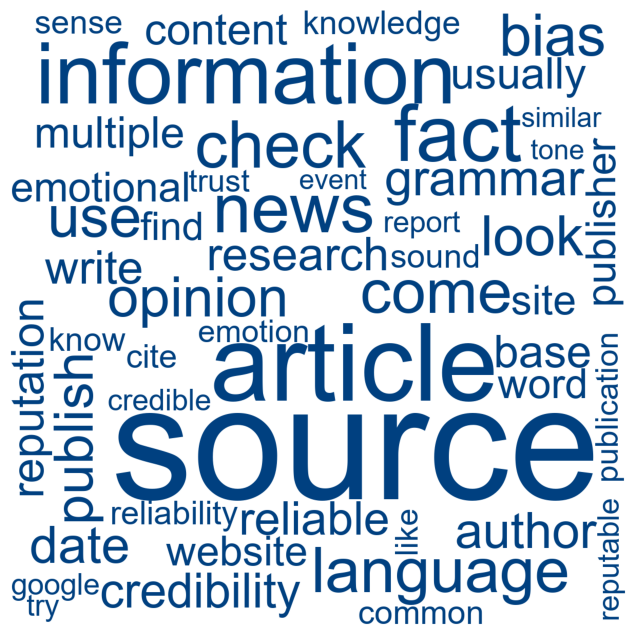

In [ ]:
freqs = Counter(criteria_words)

wordcloud = generate_wordcloud(freqs)

title_text = "Most common words (with occurences):\n" + "\n".join([f"{freq[0]} ({freq[1]})" for freq in freqs.most_common(10)])


plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")

print(title_text)

plt.show()

#### Wordcloud for additional functionality and other information wish

Most common words (with occurences):
source (342)
article (226)
information (124)
ai (111)
link (77)
news (54)
author (45)
fact (43)
check (39)
think (38)


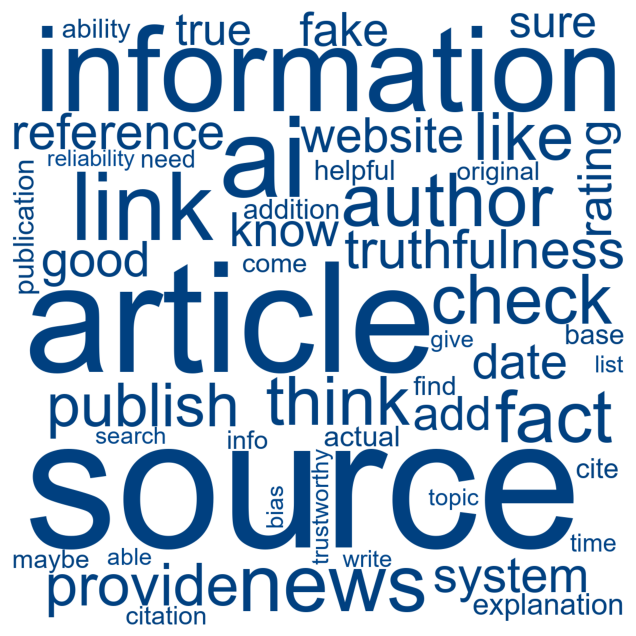

In [ ]:
freqs = Counter(wish_words)

wordcloud = generate_wordcloud(freqs)

title_text = "Most common words (with occurences):\n" + "\n".join([f"{freq[0]} ({freq[1]})" for freq in freqs.most_common(10)])

# plot the WordCloud image
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")

print(title_text)

plt.show()

### Qualitative analysis of answers

Most common answers to the question *"What criteria do you usually use to judge whether a news/article is reliable?"*:

1. Source (mentioned as source, publishing source), credibility of the source, reputation of the source/publisher -- 55.42% of answers mention the term "source"
2. Author, information about the author
3. Preexisting knowledge and common sense
4. Fact-checking, using multiple sources, googling the information
5. Language usage (grammar, spelling, emotional language)
6. Bias (perceived biases, political balance, unbiased terms)
7. Objectivity (facts vs opinions)
8. Use of citations and references

In [ ]:
# based on the 50 most frequent words
topic_words_dict = {
    "source": [
        "source", "article", "credibility",
        "reputation", "publish", "publisher", 
        "reliability", "reputable", "credible"
    ],
    "author": ["author", "write"],
    "knowledge": ["knowledge", "know", "common", "sense"],
    "fact check": ["fact", "check", "research", "google"],
    "language": ["language", "grammar", "emotional", "emotion", "tone"],
    "bias": ["bias"],
    "objectivity": ["opinion"],
    "citations": ["cite"]
}

for topic, words in topic_words_dict.items():
    contain_ratio = criteria_df[words].any(axis=1).mean()
    print(f"Topic '{topic}': {contain_ratio * 100:.4f}% (contains any of the words: {', '.join(words)})")

Topic 'source': 68.9655% (contains any of the words: source, article, credibility, reputation, publish, publisher, reliability, reputable, credible)
Topic 'author': 7.1429% (contains any of the words: author, write)
Topic 'knowledge': 7.3892% (contains any of the words: knowledge, know, common, sense)
Topic 'fact check': 16.0099% (contains any of the words: fact, check, research, google)
Topic 'language': 13.7931% (contains any of the words: language, grammar, emotional, emotion, tone)
Topic 'bias': 5.6650% (contains any of the words: bias)
Topic 'objectivity': 4.9261% (contains any of the words: opinion)
Topic 'citations': 2.4631% (contains any of the words: cite)


Answers to the question *"What functionality would be a good addition?"* and *"What other information would you like to obtain to better assess the truthfulness of an article?"* are very similar and for this reason are analyzed together. Any topic that was mentioned by multiple participants or could be interesting for future development is listed below.

1. More information about the source of the article
  - Add the actual original sources, links to the source, name of the publisher and author (not just Trustworthy/Untrustworthy source)
  - Explain why the source is trustworthy or untrustworthy
  - Show the type of source (blog, online/print newspaper, tabloid etc.)
  - Show the date of publication
2. Reference other sources of information
  - Add citations and references used by the article for each claim
  - Show a 2nd article or alternative source or alternative AI rating
  - Add a search query, a direct link to a Google search
  - Add information from human fact-checkers or fact checking websites
3. Bias
  - Provide information about bias or political balance of the source and author
4. Grammar and spelling
  - Highlight grammar and spelling mistakes
5. More information on the AI
  - Show information about who "programmed/coded" the AI
  - Show the sources used by the AI
  - Add explanations why the AI rated the article as it did (*note: analysis of this follows below*)
6. Advanced AI detection
  - Detect if images or videos are fake
  - Detect if the article is AI generated
7. Feedback feature
  - Enable users to give feedback on the AI rating
  - Noticed mistakes
8. Misc
  - Add a read-aloud functionality

In [ ]:
topic_words_dict = {
  "source": [
    "source", "article", "author",
    "publish", "link", "website",
    "actual", "original"
  ],
  "references": [
    "reference", "cite", "list",
    "citation"
  ],
  "bias": [
    "bias"
  ],
  "language": [],
  "ai": [
    "ai",
    "explanation"
  ],
  "advanced ai": [],
  "feedback": [],
  "read out loud": []
}

for topic, words in topic_words_dict.items():
    if not words:
        continue

    contain_ratio = wish_df[words].any(axis=1).mean()
    print(f"Topic '{topic}': {contain_ratio * 100:.4f}% (contains any of the words: {', '.join(words)})")

Topic 'source': 76.3547% (contains any of the words: source, article, author, publish, link, website, actual, original)
Topic 'references': 12.8079% (contains any of the words: reference, cite, list, citation)
Topic 'bias': 2.9557% (contains any of the words: bias)
Topic 'ai': 24.8768% (contains any of the words: ai, explanation)


### Export open questions for labeling

For a more in depth analyses the answers were coded with two labels:
- **No addition**: the answer does not contain any information that can be used to improve the system
- **Requests explanation**: the answer requests more information on how the AI score was determined, what parameters the AI uses. Answers requesting the "original sources" of the article or "sources used by the AI" were not included in this category.

The hypothesis is that participants in the baseline (basic) group would be more likely to request an explanation or ask for any other improvement than participants in the other two groups. This hypothesis is tested with a chi-squared test.

In [ ]:
df[criteria_col].sort_values(key=lambda x: x.str.len()).to_csv("./data/criteria.csv")

In [ ]:
df[add_func_col].sort_values(key=lambda x: x.str.len()).to_csv("./data/additional-functionality.csv")

In [ ]:
df[other_info_col].sort_values(key=lambda x: x.str.len()).to_csv("./data/other-information-wish.csv")

### Import labeled data

In [ ]:
add_df = pd.read_csv("./data/additional-functionality-labeled.csv")
add_df = add_df.rename(columns={"Unnamed: 0": "response_id", 
                                "no_addition": "additional-functionality.no-addition",
                                "requests_explanation": "additional-functionality.requests-explanation",})
add_df = add_df.drop(columns=[add_func_col])

add_df["additional-functionality.no-addition"] = add_df["additional-functionality.no-addition"].astype(bool)
add_df["additional-functionality.requests-explanation"] = add_df["additional-functionality.requests-explanation"].astype(bool)

In [ ]:
other_info_df = pd.read_csv("./data/other-information-wish-labeled.csv")
other_info_df = other_info_df.rename(columns={"Unnamed: 0": "response_id",
                                              "no_addition": "other-information-wish.no-addition",
                                              "requests_explanation": "other-information-wish.requests-explanation",})
other_info_df = other_info_df.drop(columns=[other_info_col])

# convert the labels to booleans
other_info_df["other-information-wish.no-addition"] = other_info_df["other-information-wish.no-addition"].astype(bool)
other_info_df["other-information-wish.requests-explanation"] = other_info_df["other-information-wish.requests-explanation"].astype(bool)

In [ ]:
import pandas as pd

df["response_id"] = df.index

# Define columns to add
columns_to_add = [
  "additional-functionality.no-addition",
  "additional-functionality.requests-explanation",
  "other-information-wish.no-addition",
  "other-information-wish.requests-explanation",
]

# Drop columns if they exist in df (this happens when you run this cell multiple times)
for col in columns_to_add:
  if col in df.columns:
    df = df.drop(columns=[col])

# Join df with add_df and other_info_df on response_id
df = df.join(add_df.set_index("response_id"), on="response_id")
df = df.join(other_info_df.set_index("response_id"), on="response_id")

df = df.drop(columns=["response_id"])

In [ ]:
df["requests-explanation"] = df["additional-functionality.requests-explanation"] | df["other-information-wish.requests-explanation"]

### Analysis of labeled data

##### Requests explanation

It is tested using a chi-squared test if there is a significant difference in the number of participants expressing the need for explanations between the groups. (Users are expressing the need for explanations if they mention it in at least one of the two related open ended questions) This provides a measure of how well the AI system is able to explain its decisions using the different XAI methods.

In [ ]:
expected, actual, stats = pg.chi2_independence(df, x="requests-explanation", y="FEATURE")

In [ ]:
highlight(stats)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,10.126551,2.000000,0.006325,0.157931,0.820526
1,cressie-read,0.666667,9.931185,2.000000,0.006974,0.156400,0.812595
2,log-likelihood,0.000000,9.637345,2.000000,0.008078,0.154069,0.800116
3,freeman-tukey,-0.500000,9.496171,2.000000,0.008668,0.152937,0.793880
4,mod-log-likelihood,-1.000000,9.419108,2.000000,0.009009,0.152315,0.790409
5,neyman,-2.000000,9.450474,2.000000,0.008869,0.152568,0.791827


In [ ]:
df.groupby("FEATURE")["requests-explanation"].value_counts(normalize=True).to_frame()

requests-explanation
FEATURE      requests-explanation                      
basic        False                             0.796992
             True                              0.203008
explanations False                             0.917293
             True                              0.082707
salient      False                             0.900000
             True                              0.100000

The low p value (<0.01) shows that there is a significant difference in the participants satisfaction with the AI being able to explain its decisions. While in the baseline group 20% of the participants expressed the need for explanations, in the other two groups this was only 10% and 8% in versions 2 and 3 respectively.

#### No addition

It is tested using a chi-squared test if there is a significant difference in the number of participants expressing the need for additional information. This provides a measure of how well the entire system is able to provide the information the participants need to make a decision.

In [ ]:
expected, actual, stats = pg.chi2_independence(df, x="other-information-wish.no-addition", y="FEATURE")

In [ ]:
highlight(stats)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,1.791423,2.000000,0.408317,0.066426,0.205716
1,cressie-read,0.666667,1.795184,2.000000,0.407550,0.066495,0.206073
2,log-likelihood,0.000000,1.808912,2.000000,0.404762,0.066749,0.207373
3,freeman-tukey,-0.500000,1.824801,2.000000,0.401559,0.067042,0.208878
4,mod-log-likelihood,-1.000000,1.845683,2.000000,0.397388,0.067424,0.210859
5,neyman,-2.000000,1.903339,2.000000,0.386096,0.068469,0.216336


In [ ]:
df.groupby("FEATURE")["other-information-wish.no-addition"].value_counts(normalize=True).to_frame()

other-information-wish.no-addition
FEATURE      other-information-wish.no-addition                                    
basic        False                                                         0.909774
             True                                                          0.090226
explanations False                                                         0.932331
             True                                                          0.067669
salient      False                                                         0.885714
             True                                                          0.114286

High p values (>0.05) show that there is no significant difference in the participants satisfaction with the AI being able to provide the information they need to make a decision. In all three groups ~90% of the participants answered the question about additional information with a meaningful answer.